# Group One
## CSC 7333 - Machine Learning project
### Comparative Study of Machine Learning Models for Fake News Detection
### Andrew Okafor, Dillon Jones, Lin Zeng, Miriam Nnadili, Shaojing Tian, Zack Loken

#### Due to the increasing amount of disinformation spreading across the internet, fake news detection using machine learning methods for natural language processing has recently gained much attention. The objective of this project is to compare various machine learning models’ performance in detecting fake news via text classification to see which models perform best. This study used annotated text from various news articles to train and evaluate different classifiers, including logistic regression, naïve Bayes (Gaussian and multinomial), support vector machine, random forest and recurrent neural network hybridize model. The performance on the prediction of accuracy and computational cost for all five classifiers was also compared.


In [1]:
# Original data can be found here: https://www.uvic.ca/ecs/ece/isot/datasets/fake-news/index.php

# Import necessary Python libraries, modules, etc.
import time # for generating timestamps 
import re # for regular expressions
import string as st # for removing punctuation
import numpy as np # for linear algebra
import pandas as pd # for frame processing
import matplotlib.pyplot as plt # for data visualization
import seaborn as sns
import pickle
import nltk # for natural language processing
from nltk.corpus import stopwords # for removing english stopwords
from nltk.stem import WordNetLemmatizer # for term stemming
import sklearn # for predictive data analysis
from sklearn import preprocessing # for data preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split # for splitting data into test/train sets
from sklearn.feature_extraction.text import TfidfVectorizer # for text vectorization
from wordcloud import WordCloud, ImageColorGenerator
from IPython.core.interactiveshell import InteractiveShell # to modify Jupyter notebook configuration
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from scipy.stats import uniform
from sklearn.linear_model import LogisticRegression
InteractiveShell.ast_node_interactivity = "all" # so that all outputs in a cell are returned (instead of last instance)

### Load data

In [2]:
true_news = pd.read_csv('true.csv')
fake_news = pd.read_csv('fake.csv')
true_news['label'] = 'true'  # add an extra column (named "label") to the true_news dataframe and assign true to all row in this column
fake_news['label'] = 'fake' # add an extra column (named "label") to the fake_news dataframe and assign fake to all row in this column

#compare the labels to see if the data is balanced
print(true_news['label'].value_counts())
print(fake_news['label'].value_counts())

#randomly remove (n = 2064) rows from the fake_news data frame to balance the labels
np.random.seed(5) #you can also use np.random.seed(1) This displays the same random numbers. 
fake_news = fake_news.drop(np.random.choice(fake_news.index, 2064, replace=False))

#compare the labels to see if the data is balanced
print(true_news['label'].value_counts())
print(fake_news['label'].value_counts())

news_data = pd.concat([true_news,fake_news]) # concatenate the fake_news and true_news dataframe 
news_data

true    21417
Name: label, dtype: int64
fake    23481
Name: label, dtype: int64
true    21417
Name: label, dtype: int64
fake    21417
Name: label, dtype: int64


,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",true
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",true
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",true
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",true
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",true
...,...,...,...,...,...
23476,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016",fake
23477,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016",fake
23478,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016",fake
23479,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016",fake


### Label data

In [3]:
news_data['target'] = LabelEncoder().fit_transform(news_data['label'])  # add an extra column (named "target") which is a transformation of the "label" column from text (true or fake) to numbers (1 or 0) using Labelencoder, fit_transform method
print(news_data)

news_data['text'] = news_data['title'] + news_data['text'] # merge the "title" and "text" to replace the "text" column
news_data = news_data[['text','target']] #isolate the merged "text" and the "target" column
print(news_data)

                                                   title  \
0      As U.S. budget fight looms, Republicans flip t...   
1      U.S. military to accept transgender recruits o...   
2      Senior U.S. Republican senator: 'Let Mr. Muell...   
3      FBI Russia probe helped by Australian diplomat...   
4      Trump wants Postal Service to charge 'much mor...   
...                                                  ...   
23476  McPain: John McCain Furious That Iran Treated ...   
23477  JUSTICE? Yahoo Settles E-mail Privacy Class-ac...   
23478  Sunnistan: US and Allied ‘Safe Zone’ Plan to T...   
23479  How to Blow $700 Million: Al Jazeera America F...   
23480  10 U.S. Navy Sailors Held by Iranian Military ...   

                                                    text       subject  \
0      WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1      WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2      WASHINGTON (Reuters) - The special counsel inv... 

### Data preprocessing

In [4]:
# Define function for cleaning data
wnl = WordNetLemmatizer()
nltk.download('wordnet')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

#this would act on every text in each row (pre-processing the text)
def data_cleaning(text):
    text = text.lower() # to convert the text to lowercase
    text = re.sub('[^a-zA-Z]', ' ',text) # to remove number and special characters 
    text = text.split()  #to tokenize the text
    text = [wnl.lemmatize(word) for word in text if not word in stop_words] #to lemmatize and remove stopwords
    text = [word for word in text if len(word) >=3] #remove 3 or less characters; only keep words of length greater than 3
    text = ' '.join(text) #to join all tokenized words
    return text
    
news_data['text'] = news_data['text'].apply(lambda x: data_cleaning(x))  # apply this to every row in the text column
news_data

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mnnadi1\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mnnadi1\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

C:\Users\mnnadi1\AppData\Local\Temp\ipykernel_22188\4084964411.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_data['text'] = news_data['text'].apply(lambda x: data_cleaning(x))  # apply this to every row in the text column


,text,target
0,budget fight loom republican flip fiscal scrip...,1
1,military accept transgender recruit monday pen...,1
2,senior republican senator let mueller job wash...,1
3,fbi russia probe helped australian diplomat ti...,1
4,trump want postal service charge much amazon s...,1
...,...,...
23476,mcpain john mccain furious iran treated sailor...,0
23477,justice yahoo settle mail privacy class action...,0
23478,sunnistan allied safe zone plan take territori...,0
23479,blow million jazeera america finally call quit...,0


### Splitting data

In [5]:
X = news_data.iloc[:, 0]
y = news_data.iloc[:, 1]
train_data, test_data, train_target, test_target = train_test_split(X, y, random_state = 5, train_size = 0.80) #here you can set random state to 0,1,5 etc. you will have same result for each run. However, setting this to 'None' would yield different results.

### Hyperparameter tuning

In [6]:
# with max_features=1000 and ngram_range=(1,3) further search for combinations of optimal hyperparameters of 4 classifiers
vectorizer = TfidfVectorizer(max_features=1000, lowercase=False, ngram_range=(1,3))
vec_train_data = vectorizer.fit_transform(train_data).toarray()
vec_test_data = vectorizer.fit_transform(test_data).toarray()

In [7]:
# do randomized search for optimal hyperparameters of Support Vector Machine classifier
model_SVC = RandomizedSearchCV(SVC(gamma='auto'), 
                           {'C':[1, 10, 20], 'kernel':['rbf','linear']},
                           cv=5, return_train_score=False, n_iter=2)

model_SVC.fit(vec_train_data, train_target)

df = pd.DataFrame(model_SVC.cv_results_)
print(df[['param_C', 'param_kernel', 'mean_test_score']])
print (f'The best score for Suppport Vector Machine is {model_SVC.best_score_}')
print (f'The best set of Support Vector Machine hyperparameters are {model_SVC.best_params_}')

RandomizedSearchCV(cv=5, estimator=SVC(gamma='auto'), n_iter=2,
                   param_distributions={'C': [1, 10, 20],
                                        'kernel': ['rbf', 'linear']})

  param_C param_kernel  mean_test_score
0       1       linear         0.992267
1      10          rbf         0.970876
The best score for Suppport Vector Machine is 0.992266616410969
The best set of Support Vector Machine hyperparameters are {'kernel': 'linear', 'C': 1}


In [8]:
# do randomized search for optimal hyperparameters of MultinomialNB classifier
parameters = {'alpha':[0.00001,0.0005, 0.0001,0.005,0.001,0.05,0.01,0.1,0.5,1,5,10,50,100]}
model_MNB = RandomizedSearchCV(MultinomialNB(class_prior=[0.5, 0.5]), parameters,n_jobs = -1, cv= 5, scoring='roc_auc')

model_MNB.fit(vec_train_data, train_target)

df = pd.DataFrame(model_MNB.cv_results_)
print (df[['param_alpha', 'mean_test_score']])
print (f'The best score for MultinomialNB is {model_MNB.best_score_}')
print (f'The best set of MultinomialNB hyperparameters are {model_MNB.best_params_}')

RandomizedSearchCV(cv=5, estimator=MultinomialNB(class_prior=[0.5, 0.5]),
                   n_jobs=-1,
                   param_distributions={'alpha': [1e-05, 0.0005, 0.0001, 0.005,
                                                  0.001, 0.05, 0.01, 0.1, 0.5,
                                                  1, 5, 10, 50, 100]},
                   scoring='roc_auc')

  param_alpha  mean_test_score
0         0.1         0.982869
1          10         0.980679
2      0.0001         0.983521
3         100         0.979237
4     0.00001         0.983628
5           1         0.982164
6       0.001         0.983383
7       0.005         0.983260
8        0.05         0.982992
9      0.0005         0.983429
The best score for MultinomialNB is 0.9836281805030532
The best set of MultinomialNB hyperparameters are {'alpha': 1e-05}


In [9]:
# do randomized search for optimal hyperparameters of Random Forest classifier

from scipy.stats import randint as sp_randint
param_dist = {"max_depth": [3, None],
              "max_features": sp_randint(1, 11),
              "min_samples_split": sp_randint(2, 11),
              "min_samples_leaf": sp_randint(1, 11),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"],
              "n_estimators":[10, 20,  30,  40, 50, 80,100,150, 200]}

model_RFC = RandomizedSearchCV(RandomForestClassifier(), param_distributions=param_dist,
                                   n_iter=20)
model_RFC.fit(vec_train_data, train_target)

df = pd.DataFrame(model_RFC.cv_results_)
print (df[['param_bootstrap','param_criterion','param_max_depth','param_max_features','param_min_samples_leaf','param_min_samples_split','mean_test_score']])
print (f'The best score for Random Forest Classifier is {model_RFC.best_score_}')
print (f'The best set of Random Forest Classifier hyperparameters are {model_RFC.best_params_}')

RandomizedSearchCV(estimator=RandomForestClassifier(), n_iter=20,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [3, None],
                                        'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000017703013DF0>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000017701887190>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000176ED6F4A00>,
                                        'n_estimators': [10, 20, 30, 40, 50, 80,
                                                         100, 150, 200]})

   param_bootstrap param_criterion param_max_depth param_max_features  \
0            False            gini               3                  3   
1             True            gini            None                  7   
2             True         entropy               3                  9   
3            False         entropy               3                  8   
4            False         entropy            None                  7   
5            False            gini               3                  2   
6             True            gini               3                  4   
7             True         entropy            None                  3   
8            False            gini               3                 10   
9             True            gini            None                 10   
10           False            gini               3                  7   
11           False            gini            None                  5   
12           False         entropy            None 

In [10]:
# do randomized search for optimal hyperparameters of Logistic Regression classifier
from scipy.stats import loguniform
space = dict()
space['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
space['penalty'] = ['none', 'l1', 'l2']
space['C'] = loguniform(1e-5, 100)
model_LRC = RandomizedSearchCV(LogisticRegression(), space, n_iter=20, scoring='accuracy', n_jobs=-1, cv=5, random_state=1)

model_LRC.fit(vec_train_data, train_target)

df = pd.DataFrame(model_LRC.cv_results_)
print (df[['param_C', 'param_penalty','param_solver','mean_test_score']])
print (f'The best score for Logistics regression is {model_LRC.best_score_}')
print (f'The best set of Logistic Regression Classifier hyperparameters are {model_LRC.best_params_}')

C:\Users\mnnadi1\.conda\envs\yanma\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
40 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\mnnadi1\.conda\envs\yanma\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\mnnadi1\.conda\envs\yanma\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\mnnadi1\.conda\envs\yanma\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in

RandomizedSearchCV(cv=5, estimator=LogisticRegression(), n_iter=20, n_jobs=-1,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000177018875E0>,
                                        'penalty': ['none', 'l1', 'l2'],
                                        'solver': ['newton-cg', 'lbfgs',
                                                   'liblinear']},
                   random_state=1, scoring='accuracy')

      param_C param_penalty param_solver  mean_test_score
0    0.008301          none    newton-cg         0.990311
1     0.00001            l1    newton-cg              NaN
2    0.000044          none        lbfgs         0.990603
3    0.487778            l1    liblinear         0.993551
4    8.398011            l1    liblinear         0.994747
5    0.046972          none    liblinear              NaN
6    0.000405            l2    liblinear         0.922199
7   24.988154            l1        lbfgs              NaN
8    0.000096          none    liblinear              NaN
9    4.029136            l1        lbfgs              NaN
10   0.701873            l1    newton-cg              NaN
11  18.291387          none    newton-cg         0.990311
12   0.000019            l2        lbfgs         0.503867
13   0.493965            l2        lbfgs         0.981119
14    0.00763          none    newton-cg         0.990311
15   0.001617          none    liblinear              NaN
16   6.956322 

In [22]:
model_RFC = RandomForestClassifier(criterion = 'entropy', bootstrap = False, max_depth = None, max_features = 7, 
                                   min_samples_leaf = 4, min_samples_split = 7, n_estimators = 200).fit(vec_train_data, train_target)

<Figure size 504x360 with 0 Axes>

<AxesSubplot:>

Text(0.5, 24.0, 'Predicted')

Text(42.0, 0.5, 'Actual')

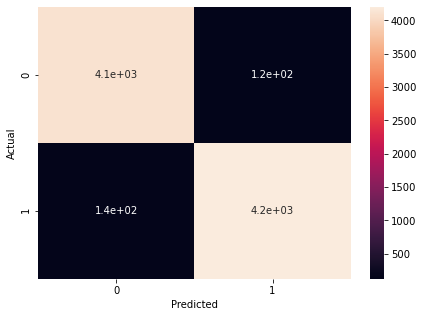

In [23]:
#Plotting confusion matrix for the best classifier (Random forest)
y_pred = model_RFC.predict(vec_test_data)
cm = confusion_matrix(test_target, y_pred)
plt.figure(figsize = (7, 5))
sns.heatmap (cm, annot = True)
plt.xlabel('Predicted')
plt.ylabel('Actual')

In [24]:
print(classification_report(test_target, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      4224
           1       0.97      0.97      0.97      4343

    accuracy                           0.97      8567
   macro avg       0.97      0.97      0.97      8567
weighted avg       0.97      0.97      0.97      8567



The confusion matrix is a way to express how many of a classifiers predictions were correct, and when incorrect, 
where the classifiers got confused. In the confusion matrices above, the rows represent the actual labels and the columns 
represent predicted labels. Values in the diagonal represent the number of times where the predicted label matches the 
true (actual) label. While the values in the other cells represent instances where the classifier mislabelled an obsservation; the column indicates the classifier predicted, and the row shows teh actual label.

In [25]:
pickle.dump(model_RFC, open('model_RFC.pkl', 'wb'))